In [50]:
# Import Modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#modeling tools
import statsmodels.api as sm

import lightgbm as lgb

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error, confusion_matrix, auc, roc_auc_score, roc_curve, log_loss, make_scorer
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

import sys
sys.path.append('../')
from src.models.agg_catboost import agg_catboost

%matplotlib inline
plt.style.use('dark_background')

%load_ext autoreload
%autoreload 2

# pd.set_option('display.min_row', 25)
pd.set_option('display.max_column', 100)
pd.set_option('display.max_colwidth', 300)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
blocks = pd.read_csv('../data/processed/blocks_sev_score.csv', index_col=0)
intersections = pd.read_csv('../data/processed/intersections_sev_score.csv', index_col=0)
circles = pd.read_csv('../data/processed/circles_sev_score.csv', index_col=0)
crosswalks = pd.read_csv('../data/processed/crosswalks_sev_score.csv', index_col=0)

# Blocks

In [34]:
blocks.columns

Index(['location', 'artdescript', 'speedlimit', 'segdir', 'oneway',
       'surfacetype_1', 'nationhwysys', 'streettype', 'tranclass',
       'trandescript', 'slope_pct', 'parkboulevard', 'year', 'count',
       'total fatalities', 'total serious injuries', 'total evident injuries',
       'total possible injuries', 'total vehicles',
       'total pedestrians involved', 'total bicyclists involved',
       'weigh_fatalities', 'weigh_serious', 'weigh_evident', 'weigh_possible',
       'sev_score'],
      dtype='object')

In [37]:
# drop columns that would need to be collected at scene of collision
b_to_drop = ['count', 'year', 'total fatalities', 'total serious injuries', 'total evident injuries',
       'total possible injuries', 'total vehicles', 'trandescript',
       'total pedestrians involved', 'total bicyclists involved',
       'weigh_fatalities', 'weigh_serious', 'weigh_evident', 'weigh_possible']

blocks.drop(columns=b_to_drop, inplace=True)

In [68]:
distinct_blocks = blocks.groupby(['location', 'artdescript', 'speedlimit', 'segdir', 'oneway', 'tranclass',
       'surfacetype_1', 'nationhwysys', 'streettype','slope_pct', 'parkboulevard']).sum().reset_index()

In [80]:
distinct_blocks.loc[7430, 'segdir'] = 'E'

In [81]:
distinct_blocks.head()

,location,artdescript,speedlimit,segdir,oneway,tranclass,surfacetype_1,nationhwysys,streettype,slope_pct,parkboulevard,sev_score
0,10TH AVE BETWEEN E ALDER ST AND E TERRACE ST,Not Designated,20.0,N,N,0,AC,N,Urban Village Neighborhood Access,1.0,N,0.000062
1,10TH AVE BETWEEN E FIR ST AND DEAD END 1,Not Designated,20.0,N,N,0,PCC,N,Urban Village Neighborhood Access,4.0,N,0.000000
2,10TH AVE BETWEEN E MADISON ST AND E SENECA ST,Not Designated,20.0,N,N,0,AC,N,Urban Village Neighborhood Access,1.0,N,0.000084
3,10TH AVE BETWEEN E PIKE ST AND E PINE ST,Not Designated,20.0,N,N,0,AC,N,Urban Village Neighborhood Access,2.0,N,0.000369
4,10TH AVE BETWEEN E SENECA ST AND E UNION ST,Not Designated,20.0,N,N,0,AC,N,Urban Village Neighborhood Access,1.0,N,0.000026


In [83]:
distinct_blocks['parkboulevard'] = distinct_blocks['parkboulevard'].map({'Y':1, 'N':0})
distinct_blocks['nationhwysys'] = distinct_blocks['nationhwysys'].map({'Y':1, 'N':0})
distinct_blocks['oneway'] = distinct_blocks['oneway'].map({'Y':1, 'N':0})

#### Target and Features

In [84]:
y = distinct_blocks.pop('sev_score')

In [85]:
X = distinct_blocks.drop(columns='location').copy()

In [87]:
X.head()

,artdescript,speedlimit,segdir,oneway,tranclass,surfacetype_1,nationhwysys,streettype,slope_pct,parkboulevard
0,Not Designated,20.0,N,0,0,AC,0,Urban Village Neighborhood Access,1.0,0
1,Not Designated,20.0,N,0,0,PCC,0,Urban Village Neighborhood Access,4.0,0
2,Not Designated,20.0,N,0,0,AC,0,Urban Village Neighborhood Access,1.0,0
3,Not Designated,20.0,N,0,0,AC,0,Urban Village Neighborhood Access,2.0,0
4,Not Designated,20.0,N,0,0,AC,0,Urban Village Neighborhood Access,1.0,0


In [88]:
cat_feats = ['artdescript', 'segdir', 'surfacetype_1', 'streettype']

clf = agg_catboost(X, y, cat_feats)

In [89]:
clf.train_model()

'Training on 5 k-folds complete'

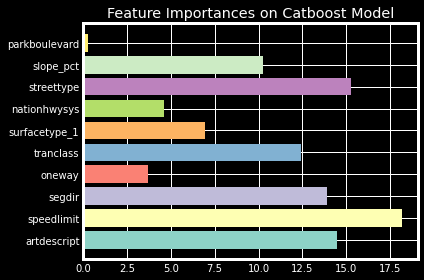

In [100]:
clf.plot_feature_importances()
plt.savefig('../reports/blocks_cat_featimport.png')

# Intersections

# Circles

# Crosswalks